# WHONDRS data preprocessing notebook

We want to predict sediment respiration rates based on:
1. site data (in situ water samples - isotopes, chemical conc./presence)
2. intermediate scale data (site metadata, e.g. what an observer sees)
3. large scale data (satellite data, stream order)

This notebook will preprocess the WHONDRS data for use with machine learning. 
In this case, preprocessing means pulling out exactly the data to be used 
and applying any reformatting/reordering needed to create a single input file 
for the machine learning.

There are multiple respiration rates per site because they come from
upstream, midstream, and downstream sampling locations.  Some site
metadata encompass the whole site and other metadata are specific to
the U, M, and D "subsites".  Here, we attempt to keep U, M, and D
data points as separate as possible.

The data sets merged here are:
1. WHONDRS **sediment** respiration rate (the target variable for predictions), 
2. WHONDRS site metadata (range of scales, recorded by observers),
3. WHONDRS **sediment** FTICR chemical presence/absence,
4. WHONDRS site data (isotopes, C and N percentages, flow cytometry, grain size, and NPOC).

(#1 and #2 are already pre-merged).

Large scale data from RiverATLAS (stream order, water depth, climatic and land use
indices) are merged separately during ML workflow execution. This additional
merge is carried out seprately because it draws on data outside of WHONDRS while
all data merged here are WHONDRS S19S data.  WHONDRS S19S has a broader range of input
variables (i.e. features) than subsequent WHONDRS ICON-ModEx and SSS sampling.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

# Full path of directory that contains WHONDRS data
csv_path = "~/global-river-databases/WHONDRS/"

# Load respiration rate and site observer metadata

Respiration rate will be the key output of the ML models.  The presence/absence of data from each site in this data set determines all other record queries.

In [2]:
# Load the metadata (md) and 
# respiration rate (rr) data.
# Here, the Sample_ID can be used 
# to access a whole sample, e.g.:
# df_site_meta.loc['S19S_0001-U',:]
df_md_rr = pd.read_csv(
    csv_path+"ICON-ModEx_Data.csv",
    index_col='Sample_ID',
    header=0)

# Set a dictionary with the variables to be used
# (the column name in the file) and the data type.
md_rr_data_to_use = {
    'Sample_Longitude':np.dtype('float'),
    'Sample_Latitude':np.dtype('float'), 
    #'Sample_Kit_ID', # Not unique; use Sample_ID as DF index
    #'Date', 
    #'Median_Time_Unix', 
    #'Median_Time_Local',
    #'Local_Timezone',
    'Mean_DO_mg_per_L':np.dtype('float'),
    #'DO_sd',
    'Mean_DO_percent_saturation':np.dtype('float'),
    #'DO_percent_saturation_sd',
    'Mean_Temp_Deg_C':np.dtype('float'),
    #'Temp_sd',
    #'Respiration_Rate_mg_DO_per_L_per_H':np.dtype('float'), # Highly correlated with Norm. RR below
    'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment':np.dtype('float'), 
    #'Type',
    #'Respiration_R_Squared':np.dtype('float'),      # Drop the data associated with the respiration rate
    #'Respiration_R_Squared_Adj':np.dtype('float'),  # since they only apply to situations where we actually
    #'Respiration_p_value':np.dtype('float'),        # have the respiration rate, which defeats the point of
    #'Total_Incubation_Time_Min':np.dtype('float'),  # making ML predictions of respiration rate.
    #'Number_Points_In_Respiration_Regression':np.dtype('float'),
    #'Number_Points_Removed_Respiration_Regression':np.dtype('float'),
    #'DO_Concentration_At_Incubation_Time_Zero':np.dtype('float'),  # Highly correlated with RR, normalized
    #'Site_ID', # Not unique for each row; use Sample_ID as DF index.
    #'MiniDot_Latitude',
    #'MiniDot_Longitude', 
    #'MiniDot_Start_Time', 
    #'MiniDot_End_Time',
    #'MiniDot_ID', 
    'pH':np.dtype('float'), 
    #'Contact_First_Name', 
    #'Contact_Last_Name',
    #'Organization', 
    #'Email', 
    #'Site_Name', 
    #'Stream_Name', 
    #'City', 
    #'State',
    #'Country', 
    #'Weather', 
    'Intermittent_or_Perennial':'category', 
    'General_Vegetation':'category',
    'Hydrogeomorphology':'category', 
    'River_Gradient':'category', 
    'MiniDot_Sediment':'category',
    #'Water_Temperature':np.dtype('float'), # String values, duplicate of Mean_Temp_Deg_C?
    'Water_Depth_cm':np.dtype('float'), 
    'Depositional_Type':'category',
    'Canopy_Cover':'category', 
    'Macrophyte_Coverage':'category', 
    'Algal_Mat_Coverage':'category',
    #'Sediment_Collection_Depth_cm':np.dtype('float'), # Does not appear to have any data for S19S
    #'MiniDot_Notes',
    #'Additional_Sampling_Notes', 
    #'Hydrograph_Online', 
    #'Hydrograph_Other',
    #'Water_volume_Flag', 
    #'Notes'
}

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# If there are any missing respiration rates, drop whole rows from the very beginning:
print('Starting with DF shape: '+str(df_md_rr.shape))

print('Retaining only S19S data...')
df_md_rr = df_md_rr.filter(axis='index', regex="S19S")

# Remove any internal commas in gradient and vegetation type
# For example, "e.g., " becomes "e.g." and
# "Grass, Shrub" becomes "Grass. Shrub".
df_md_rr['River_Gradient'] = df_md_rr['River_Gradient'].replace(',','',regex=True)
df_md_rr['General_Vegetation'] = df_md_rr['General_Vegetation'].replace(',','.',regex=True)

print('Current DF shape: '+str(df_md_rr.shape))
print('Dropping any NaN (missing) normalized respiration rates...')
df_md_rr.dropna(axis='index', subset=['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'], 
                how='any', inplace=True)
print('Current DF shape: '+str(df_md_rr.shape))

# Negative values for certain columns are replaced with nan
df_md_rr[
    df_md_rr.loc[:,[
        'Respiration_R_Squared', 
        'Respiration_R_Squared_Adj', 
        'Respiration_p_value', 
        'Total_Incubation_Time_Min',
        'Number_Points_In_Respiration_Regression',
        'Number_Points_Removed_Respiration_Regression']] < 0] = np.nan 
df_md_rr

Starting with DF shape: (699, 58)
Retaining only S19S data...
Current DF shape: (291, 58)
Dropping any NaN (missing) normalized respiration rates...
Current DF shape: (224, 58)


,Sample_Kit_ID,Date,Median_Time_Unix,Median_Time_Local,Local_Timezone,Mean_DO_mg_per_L,DO_sd,Mean_DO_percent_saturation,DO_percent_saturation_sd,Mean_Temp_Deg_C,Temp_sd,Respiration_Rate_mg_DO_per_L_per_H,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment,Type,Respiration_R_Squared,Respiration_R_Squared_Adj,Respiration_p_value,Total_Incubation_Time_Min,Number_Points_In_Respiration_Regression,Number_Points_Removed_Respiration_Regression,DO_Concentration_At_Incubation_Time_Zero,Site_ID,Sample_Latitude,Sample_Longitude,MiniDot_Latitude,MiniDot_Longitude,MiniDot_Start_Time,MiniDot_End_Time,MiniDot_ID,pH,Contact_First_Name,Contact_Last_Name,Organization,Email,Site_Name,Stream_Name,City,State,Country,Weather,Intermittent_or_Perennial,General_Vegetation,Hydrogeomorphology,River_Gradient,MiniDot_Sediment,Water_Temperature,Water_Depth_cm,Depositional_Type,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,Sediment_Collection_Depth_cm,MiniDot_Notes,Additional_Sampling_Notes,Hydrograph_Online,Hydrograph_Other,Water_volume_Flag,Notes
Sample_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S19S_0019-D,S19S_0019,8/19/2019,NaN,NaN,EST,11.46,NaN,121.9,NaN,18.3,NaN,-1.43,-4.60,Measured_10mL,0.994539,0.993629,0.000723,129.0,8.0,0.0,8.53,NaN,35.956381,-84.278999,35.9563807,-84.278999,NaN,NaN,NaN,8.0,Geoff,Schwaner,Battelle-NEON D07,NaN,National Ecological Observatory (NEON) site: WALK,Walker Branch,Oak Ridge,Tennessee,USA,Partly cloudy,Perennial,Broadleaf deciduous tree,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),18.3,6.0,Shallow waters near the shore,No or almost no direct sunlight (>80% canopy c...,Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
S19S_0019-M,S19S_0019,8/19/2019,NaN,NaN,EST,11.46,NaN,121.9,NaN,18.3,NaN,-11.47,-36.16,Measured_10mL,0.958213,0.916426,0.039935,36.0,3.0,0.0,8.13,NaN,35.956601,-84.278910,35.956601,-84.278910,NaN,NaN,NaN,8.0,Geoff,Schwaner,Battelle-NEON D07,NaN,National Ecological Observatory (NEON) site: WALK,Walker Branch,Oak Ridge,Tennessee,USA,Partly cloudy,Perennial,Broadleaf deciduous tree,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),18.3,8.0,Shallow waters near the shore,Partial direct sunlight (50-80% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
S19S_0019-U,S19S_0019,8/19/2019,NaN,NaN,EST,11.46,NaN,121.9,NaN,18.3,NaN,-3.75,-11.18,Measured_10mL,0.960563,0.940844,0.008945,47.0,4.0,0.0,8.44,NaN,35.957280,-84.278698,35.9572803,-84.278698,NaN,NaN,NaN,8.0,Geoff,Schwaner,Battelle-NEON D07,NaN,National Ecological Observatory (NEON) site: WALK,Walker Branch,Oak Ridge,Tennessee,USA,Partly cloudy,Perennial,Broadleaf deciduous tree,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),18.3,12.0,Pool lip,Partial direct sunlight (50-80% canopy cover),No,Low,NaN,NaN,NaN,NaN,NaN,False,NaN
S19S_0006-D,S19S_0006,7/29/2019,NaN,NaN,EST,NaN,NaN,NaN,NaN,25.7,NaN,NaN,-1575.97,Theoretical,NaN,NaN,NaN,NaN,NaN,NaN,4.29,NaN,39.311369,-76.717163,39.311369,-76.717163,NaN,NaN,NaN,7.5,Ben,Glass-Siegel,Baltimore Ecosystem Study,NaN,NSF Long Term Ecological Research (LTER) site:...,Dead Run,Baltimore,Maryland,USA,Sunny,Perennial,Broadleaf deciduous tree. Shrub,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),25.7,6.0,Shallow waters near the shore,Partial direct sunlight (50-80% canopy cover),No,Low,NaN,NaN,Conductivity: 1430 millisiemens. Conductivity ...,NaN,NaN,True,NaN
S19S_0006-M,S19S_0006,7/29/2019,NaN,NaN,EST,NaN,NaN,NaN,NaN,25.7,NaN,-1.05,-3.28,Measured_10mL,0.754172,0.692715,0.004980,120.0,6.0,0.0,6.77,NaN,39.311620,-76.717316,39.31162,-76.717316,NaN,NaN,NaN,7.5,Ben,Glass-Siegel,Baltimore Ecosystem Study,NaN,NSF Long Term Ecological Research (LTER) site:...,Dead Run,Baltimore,Maryland,USA,Sunny,Perennial,Broadleaf deciduous tree. Shrub,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),25.7,10.0,Inside bend 

# Load processed FTICR data into Pandas DataFrame
The three cells below divide this process into three steps:
1. loading the data and defining which FTICR indices to extract
2. a function that does the extraction for a single site, and
3. a loop over all sites that merges all FTICR inidces from all sites into one dataframe.

In [3]:
# File is compressed in repository
!gunzip -c {csv_path}FTICR/Processed_S19S_Sediments_Water_2-2_newcode.csv.adj.gz > {csv_path}FTICR/Processed_S19S_Sediments_Water_2-2_newcode.csv.adj

# In this file, site ID is in the header
# so sites/samples are along the columns 
# rather than the rows. Due to alignment
# issues, mass is not exact but we can use
# it as an index since it is the first
# column and conveniently unique.
df_fticr_raw = pd.read_csv(
    csv_path+"FTICR/Processed_S19S_Sediments_Water_2-2_newcode.csv.adj",
    header=0,
    index_col='Mass')

# Remove decompressed file to keep repo small
!rm {csv_path}FTICR/Processed_S19S_Sediments_Water_2-2_newcode.csv.adj

# Instead of transposing the dataframe and creating a new
# dataframe that is indexed by sample_id (e.g. somthing like:
# df_fticr_transposed = df_fticr.transpose().set_index()),
# note that there are U, M, and D data points as well as P2,
# p05 designations. The solution is to select columns of data
# based on sample similar to the site metadata.

# The bigger problem is that the data are not 100% consistent
# in that only some sites have U, M, D subsamples, etc.  There
# can be anywhere from 0 to 6 entries per sample_ID, some of
# which are U,M,D and some are replicates.  So here, we will
# pull out all the values associated with a sample_id, add them
# together, and any values greater than 0 are replaced with 1.
# This means all replicates, and ion-accumulation
# times (the PXX values) are merged together into a single
# presence-absence string for that site BUT all U,
# M, D sites are kept apart.  Any site that is missing (e.g.
# S19S_0001-M was not found, but S19S_0001-U was found) has
# NaN data for the FTICR features.

# We will select a string of 0's and 1's from a column based
# on the sample_id.  An alternative approach is to weight 
# the 0's and 1's based on the associated variables with 
# each chemical (e.g. AI, DBE, NOSC). For example, the 
# final value could be:
# (AI + DBE + NOSC)*(presence/absence) - but this additional
# weighting has NOT been applied.

#====================================================
# Set dictionary for mapping units of this data set
#====================================================
# Use chemical presence/absence
# to weight AI, DBE, and NOSC variables and a
# few others.  Here, I will use the column names
# in the chemical presence/absence file to generate
# a presence/absence weighted value for each variable.
# There are a few others to choose from, but these
# seem to be the most relevant.
    
fticr_data_to_use = {
    'AI':np.dtype('float'),
    'AI_Mod':np.dtype('float'),
    'DBE':np.dtype('float'),
    'DBE_O':np.dtype('float'),
    'GFE':np.dtype('float'),
    'NOSC':np.dtype('float'),
    'delGcox0PerCmol':np.dtype('float'),
    'delGcoxPerCmol':np.dtype('float'),
    'lamO20':np.dtype('float'),
    'lamO2':np.dtype('float'),
    'delGd0':np.dtype('float'),
    'delGd':np.dtype('float'),
    'n_chems':np.dtype('float'),
    'skew_lamO20':np.dtype('float'),
    'skew_lamO2':np.dtype('float'),
    'perc_AminoSugar':np.dtype('float'),
    'perc_Carb':np.dtype('float'),
    'perc_ConHC':np.dtype('float'),
    'perc_Lignin':np.dtype('float'),
    'perc_Lipid':np.dtype('float'),
    'perc_Other':np.dtype('float'),
    'perc_Protein':np.dtype('float'),
    'perc_Tannin':np.dtype('float'),
    'perc_UnsatHC':np.dtype('float')
}
    
len(fticr_data_to_use.keys())

24

In [4]:
# Function to extract FTICR data for a given site ID.

# Find all the records associated with a given
# sample_id and add up all presence/absence.
# If a Sample_ID does not specify U, M, or D
# then all those values will be combined!
def get_fticr_data(df_fticr_in, site_id, dict_index_to_use, plot_counter=1):
    
    # Sum the presence (1) and absence (0) of chemicals at the
    # site. This is done to sum over potentially different
    # ion accumulation times at each site. This filter can be
    # adjusted to exclude different _p* values.
    tmp_filter = df_fticr_in.filter(regex=site_id).sum(axis=1) > 0
    tmp_counts = tmp_filter.astype(float)
    
    # Initialize dataframe with NaN whose values will be
    # filled in.
    df_out = pd.DataFrame(np.nan,
        columns=list(dict_index_to_use.keys()),
        index=[site_id])
    
    # Check for no data found for this site
    if tmp_counts.sum() == 0:
        print('No FTICR data found for this site!')
        #return df_out.iloc[0,:]
        return df_out

    # Now, create an "average detected index" (ADI) for each
    # of the desired indices.
    for index_name in dict_index_to_use.keys():
        
        # Special case for number of chemicals
        if index_name == "n_chems":
            df_out[index_name] = tmp_counts.sum()
        
        # Special case for skew of index:
        elif index_name[0:4] == "skew":
            # Get variable to skew
            this_index = index_name[5:len(index_name)]
            adi_list = df_fticr_in[this_index]
            adi_avg = np.multiply(adi_list,tmp_counts).sum()/tmp_counts.sum()
            
            # Mask out missing values
            masked = adi_list*tmp_counts
            just_this_sample = masked[masked != 0]
            
            # Plot internal result
            if plot_counter == 0:
                fig, ax = plt.subplots()
                ax.hist(just_this_sample,bins=50)
                plt.title(index_name)
                plot_counter = 1
            
            # Compute skew
            df_out[index_name] = sp.stats.skew(just_this_sample.to_numpy(),nan_policy="omit")
            
        # Special case for percent of category
        elif index_name[0:4] == "perc":
                
            # Get the categories and name of requested category
            adi_list = df_fticr_in['Class']
            this_category = index_name[5:len(index_name)]
            categories_this_sample = adi_list[tmp_filter]
            
            total_this_sample = np.shape(categories_this_sample)[0]
            present_this_category = categories_this_sample == this_category
            df_out[index_name] = present_this_category.astype(int).sum()/total_this_sample
            
        # General case
        else:        
            adi_list = df_fticr_in[index_name]
            adi_avg = np.multiply(adi_list,tmp_counts).sum()/tmp_counts.sum()
            df_out[index_name] = adi_avg
            
    # Done with ADI looping, but still need to change
    # the dataframe into exactly the same format
    # as the other data sets' dataframes
    #return df_out.iloc[0,:]
    return df_out

Working on row 0 at site S19S_0019-D
Working on row 1 at site S19S_0019-M
Working on row 2 at site S19S_0019-U
Working on row 3 at site S19S_0006-D
Working on row 4 at site S19S_0006-M
Working on row 5 at site S19S_0006-U
Working on row 6 at site S19S_0007-D
No FTICR data found for this site!
Working on row 7 at site S19S_0007-U
No FTICR data found for this site!
Working on row 8 at site S19S_0008-D
No FTICR data found for this site!
Working on row 9 at site S19S_0008-M
Working on row 10 at site S19S_0008-U
No FTICR data found for this site!
Working on row 11 at site S19S_0009-D
No FTICR data found for this site!
Working on row 12 at site S19S_0009-M
Working on row 13 at site S19S_0009-U
Working on row 14 at site S19S_0010-D
Working on row 15 at site S19S_0010-M
Working on row 16 at site S19S_0010-U
Working on row 17 at site S19S_0011-D
Working on row 18 at site S19S_0011-M
Working on row 19 at site S19S_0011-U
Working on row 20 at site S19S_0015-D
Working on row 21 at site S19S_0015-M

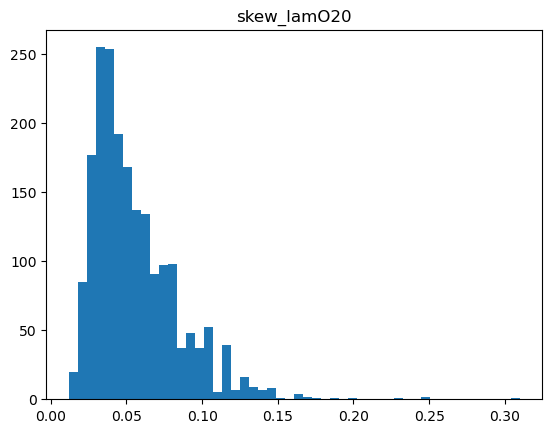

In [5]:
# Test function with one site
tmp = get_fticr_data(df_fticr_raw, 'S19S_0089-U', fticr_data_to_use,plot_counter=0)

# Accumulate FTICR data over all sites
for rr,site in enumerate(df_md_rr.index):
    print('Working on row '+str(rr)+' at site '+site)
    row_of_data = get_fticr_data(df_fticr_raw, site, fticr_data_to_use)
    #print(row_of_data.shape)
    if rr == 0:                
        # Initialize numpy array to store all the data
        df_fticr = row_of_data
        
    else:    
        # Append to the data storage
        df_fticr = pd.concat([df_fticr,row_of_data])

# Load sample isotope, NPOC, grain size, flow cytometry, and CN data

In [6]:
df_isotopes = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_Isotopes.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
isotopes_data_to_use = {
    'del_15N_permil':np.dtype('float'),
    'del_13C_permil':np.dtype('float')
}

# Drop the Study_Code from this and all following datasets
# since this duplicated information can cause merge issues later.
df_isotopes.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_isotopes.replace(to_replace=-9999, value=np.nan, inplace=True)

df_isotopes

,del_15N_permil,del_13C_permil,Date_Run
Sample_ID,,,
S19S_0001-D,1.23,-22.06,2022-10-24
S19S_0001-M,-1.28,-26.27,2022-10-24
S19S_0001-U,1.77,-23.20,2022-10-24
S19S_0003-D,2.61,-26.03,2022-10-24
S19S_0003-M,4.91,-25.32,2022-10-24
...,...,...,...
S19S_0099-M,-7.42,-2.45,2022-10-24
S19S_0099-U,-4.55,-0.70,2022-10-24
S19S_0100-D,4.82,-16.68,2022-10-24


In [7]:
df_npoc_inc = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_NPOC_INC.csv.adj",
    header=0,
    index_col='Sample_ID')

df_npoc_field = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_NPOC_Field.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
npoc_inc_data_to_use = {
    'NPOC_INC_mg_per_L_as_C':np.dtype('float')
}

npoc_field_data_to_use = {
    'NPOC_Field_mg_per_L_as_C':np.dtype('float')
}

df_npoc_inc.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_npoc_inc.replace(to_replace=-9999, value=np.nan, inplace=True)

df_npoc_inc

,NPOC_INC_mg_per_L_as_C
Sample_ID,
S19S_0044-M,14.77
S19S_0016-D,5.72
S19S_0015-D,11.21
S19S_0050-D,7.15
S19S_0032-D,25.64
...,...
S19S_0075-U,8.28
S19S_0055-U,18.88
S19S_0042-M,27.92


In [8]:
df_npoc_field.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_npoc_field.replace(to_replace=-9999, value=np.nan, inplace=True)

df_npoc_field

,NPOC_Field_mg_per_L_as_C
Sample_ID,
S19S_0067-D,24.32
S19S_0072-M,8.90
S19S_0073-U,20.24
S19S_0071-U,31.58
S19S_0064-M,21.81
...,...
S19S_0051-D,31.52
S19S_0087-U,25.61
S19S_0094-D,7.57


In [9]:
df_grainsize = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_GrainSize.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
grainsize_data_to_use = {
    'Percent_Fine_Sand':np.dtype('float'),
    'Percent_Med_Sand':np.dtype('float'),
    'Percent_Coarse_Sand':np.dtype('float'),
    'Percent_Tot_Sand':np.dtype('float'),
    'Percent_Clay':np.dtype('float'),
    'Percent_Silt':np.dtype('float')
}

df_grainsize.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_grainsize.replace(to_replace=-9999, value=np.nan, inplace=True)

df_grainsize

,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt
Sample_ID,,,,,,
S19S_0001-D,21.1,69.7,0.1,90.9,0.0,9.1
S19S_0001-M,65.3,26.0,0.6,91.9,6.9,1.2
S19S_0001-U,20.4,68.6,2.1,91.1,8.9,0.0
S19S_0003-D,29.9,56.5,0.7,87.1,2.3,10.6
S19S_0003-M,19.2,66.2,1.7,87.1,2.2,10.7
...,...,...,...,...,...,...
S19S_0099-M,9.1,34.5,47.9,91.5,8.5,0.0
S19S_0099-U,9.8,37.3,41.9,89.0,7.8,3.2
S19S_0100-D,21.0,31.3,11.9,64.2,17.7,18.1


In [10]:
df_flowcyto = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_FlowCytometry.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
flowcyto_data_to_use = {
    'Total_Bacteria_cells_per_gram':np.dtype('float'),
    'Total_Photorophs_cells_per_gram':np.dtype('float'),
    'Total_Heterotrophs_cells_per_gram':np.dtype('float')
}

df_flowcyto.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_flowcyto.replace(to_replace=-9999, value=np.nan, inplace=True)

df_flowcyto

,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram
Sample_ID,,,
S19S_0010-U,1.760000e+09,35000000.0,1.720000e+09
S19S_0010-M,2.310000e+09,53500000.0,2.260000e+09
S19S_0010-D,1.470000e+09,47000000.0,1.420000e+09
S19S_0023-U,2.200000e+09,3930000.0,2.190000e+09
S19S_0023-M,2.000000e+09,115000000.0,1.890000e+09
...,...,...,...
S19S_0052-M,3.070000e+08,39800000.0,2.670000e+08
S19S_0052-D,2.520000e+08,28200000.0,2.240000e+08
S19S_0072-U,2.780000e+08,80300000.0,1.980000e+08


In [11]:
df_cn = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_CN.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
cn_data_to_use = {
    'C_percent':np.dtype('float'),
    'N_percent':np.dtype('float')
}

df_cn.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_cn.replace(to_replace=-9999, value=np.nan, inplace=True)

df_cn

,C_percent,N_percent
Sample_ID,,
S19S_0001-D,0.24,0.10
S19S_0001-M,0.24,0.08
S19S_0001-U,0.24,0.09
S19S_0003-D,0.59,0.10
S19S_0003-M,0.54,0.11
...,...,...
S19S_0099-M,3.63,0.08
S19S_0099-U,4.03,0.09
S19S_0100-D,2.42,0.20


# Load RiverATLAS-derived stream order & other data
This data is added during the workflow execution using dynamic look up with each site's lon/lat.

# Join data for each respiration rate record

In [12]:
# Concatenate the data frames
df_all = df_md_rr.join([
    df_fticr,
    df_isotopes,
    df_npoc_inc,
    df_npoc_field,
    df_grainsize,
    df_flowcyto,
    df_cn],
    how='left')

# Concatenate the data type dictionaries for variables to use
all_data_types = md_rr_data_to_use.copy()
all_data_types.update(fticr_data_to_use)
all_data_types.update(isotopes_data_to_use)
all_data_types.update(npoc_inc_data_to_use)
all_data_types.update(npoc_field_data_to_use)
all_data_types.update(grainsize_data_to_use)
all_data_types.update(flowcyto_data_to_use)
all_data_types.update(cn_data_to_use)

# Create a view with only the data we want to use as defined
# by the dictionaries
df_data_to_use = df_all.loc[:,list(all_data_types.keys())]

# Compute columnwise statistics (mean, std, min, quantiles, max)
# For text based data, will display the number of results, number
# of unique results, most frequent result and how often that result
# occurred.
df_data_to_use.describe(include='all')

,Sample_Longitude,Sample_Latitude,Mean_DO_mg_per_L,Mean_DO_percent_saturation,Mean_Temp_Deg_C,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment,pH,Intermittent_or_Perennial,General_Vegetation,Hydrogeomorphology,River_Gradient,MiniDot_Sediment,Water_Depth_cm,Depositional_Type,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,AI,AI_Mod,DBE,DBE_O,GFE,NOSC,delGcox0PerCmol,delGcoxPerCmol,lamO20,lamO2,delGd0,delGd,n_chems,skew_lamO20,skew_lamO2,perc_AminoSugar,perc_Carb,perc_ConHC,perc_Lignin,perc_Lipid,perc_Other,perc_Protein,perc_Tannin,perc_UnsatHC,del_15N_permil,del_13C_permil,NPOC_INC_mg_per_L_as_C,NPOC_Field_mg_per_L_as_C,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram,C_percent,N_percent
count,224.000000,224.000000,119.000000,131.000000,221.000000,224.000000,224.000000,218,224,224,224,224,224.000000,224,224,224,224,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,215.000000,191.000000,222.000000,220.000000,218.000000,217.000000,218.000000,217.000000,218.000000,217.000000,1.990000e+02,1.990000e+02,1.990000e+02,219.000000,219.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,16,3,2,4,NaN,9,4,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Perennial,Needleleaf evergreen tree. Broadleaf deciduous...,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),NaN,Shallow waters near the shore,Full sunlight (0-20% canopy cover),No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187,35,116,157,129,NaN,101,85,138,148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-99.762882,40.266530,8.093109,89.593130,19.194796,-330.968929,6.998214,NaN,NaN,NaN,NaN,NaN,21.216946,NaN,NaN,NaN,NaN,0.083358,0.181776,6.838198,-0.855774,75.773984,-0.542947,75.773984,-145.999702,0.054889,0.048675,1501.315169,-2836.490136,2245.675258,1.846250,1.742847,0.069943,0.027655,0.081385,0.280167,0.120609,0.015687,0.310401,0.056629,0.037524,5.768512,-24.665497,14.635495,17.296045,19.753211,23.866359,33.282110,76.745161,12.364220,10.859908,1.862989e+09,9.248717e+07,1.770829e+09,2.729726,0.192648
std,19.555193,7.151599,2.344643,22.391795,6.517674,732.498952,0.599493,NaN,NaN,NaN,NaN,NaN,23.642967,NaN,NaN,NaN,NaN,0.009468,0.024141,0.579698,0.297670,2.834177,0.099445,2.834177,1.224611,0.003128,0.002707,94.702145,133.384307,412.633364,0.258277,0.211660,0.013130,0.009013,0.025794,0.041540,0.030506,0.004726,0.037648,0.022781,0.013023,11.169677,7.313505,9.105159,11.834152,16.303171,19.568314,27.336645,22.914202,16.166148,17.634092,2.553415e+09,2.733425e+08,2.467339e+09,5.255804,0.300488
min,-149.597200,25.409760,3.830000,41.100000,4.500000,-2907.840000,6.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,0.056706,0.125937,5.756372,-1.601590,67.640001,-0.808610,67.640001,-149.577994,0.045817,0.040997,1303.865599,-3355.429104,859.000000,1.243895,1.267510,0.028693,0.009259,0.038034,0.178113,0.045509,0.007086,0.187161,0.015042,0.009606,-24.860000,-46.410000,4.270000,3.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.470000e+07,2.980000e+04,1.450000e+07,0.120000,0.040000
25%,-116.774479,35.966300,6.550000,76.900000,14.000000,-50.477500,6.500000,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,0.077263,0.164526,6.443904,-1.044491,73.867522,-0.614216,73.867522,-146.787511,0.053035,0.047106,

# Filter missing values and map ordinal data

In [13]:
# Now we need to convert text classes into
# "one-hot" or "one-of-k" data which tells
# the ML model that the data is classicative
# but not necessarily ranked (not numerical).
# This is done with a string of 0's where each
# class is represented by exactly one of the
# zeros being changed into a 1 (so one bit is
# "hot").
#
# A starting point for one-hot
# classification is here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
#
# I will use this approach for dealing
# with missing data:
# https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
# You can tell when there's missing data in columns
# in which the count line from the .describe()
# operation is less than the total number of rows.
# The missing values are translated to a string of
# all zeros in one-hot encoding.  An unresolved
# question is whether all zeros actually means
# something or whether it is truly ignored by
# the ML model.

# Some variables are best as ORDINAL (ranking, 0, 1, 2, 3,...)
# rather than CATEGORICAL.  Define the mapping between the text
# values and the numbers first and then replace the values with
# the integers and change data type from categorical to number.

# Note here that there are multiple categoy names that correspond
# to the same categorical values - due to slight changes in how the
# data are entered as the sampling campaign evolved.
mapper = {
    'No':1, 
    'No coverage':1,
    'None':1,
    'Low':2, 
    'Partial coverage':2,
    'Low (5-30%)':2,
    'Med (30-70%)':2,
    'High':3,
    'High (>70%)':3,
    'Full coverage':3}
df_data_to_use['Macrophyte_Coverage'] = df_data_to_use['Macrophyte_Coverage'].replace(mapper)
df_data_to_use['Algal_Mat_Coverage'] = df_data_to_use['Algal_Mat_Coverage'].replace(mapper)

# Note here that there are multiple categoy names that correspond
# to the same categorical values - due to slight changes in how the
# data are entered as the sampling campaign evolved.
mapper = {
    'Full coverage':1,
    'Full sunlight (0-20% canopy cover)':1,
    'Low (5-30%)':1,
    'Med (30-70%)':2,
    'Accessible direct sunlight (20-50% canopy cover)':2,
    'Partial direct sunlight (50-80% canopy cover)':3,
    'Partial coverage':3,
    'High (>70%)':3,
    'No or almost no direct sunlight (>80% canopy cover)':4,
    'No coverage':4,
    'None':4
}
df_data_to_use['Canopy_Cover'] = df_data_to_use['Canopy_Cover'].replace(mapper)

all_data_types['Macrophyte_Coverage']=np.dtype('float')
all_data_types['Algal_Mat_Coverage']=np.dtype('float')
all_data_types['Canopy_Cover']=np.dtype('float')

# Filter out missing data in remaining CATEGORICAL data
df_data_to_use = df_data_to_use.replace('Not_Provided',np.nan)
df_data_to_use = df_data_to_use.replace('',np.nan)

# Now apply data types
df_data_to_use = df_data_to_use.astype(all_data_types)
df_data_to_use.columns

Index(['Sample_Longitude', 'Sample_Latitude', 'Mean_DO_mg_per_L',
       'Mean_DO_percent_saturation', 'Mean_Temp_Deg_C',
       'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment', 'pH',
       'Intermittent_or_Perennial', 'General_Vegetation', 'Hydrogeomorphology',
       'River_Gradient', 'MiniDot_Sediment', 'Water_Depth_cm',
       'Depositional_Type', 'Canopy_Cover', 'Macrophyte_Coverage',
       'Algal_Mat_Coverage', 'AI', 'AI_Mod', 'DBE', 'DBE_O', 'GFE', 'NOSC',
       'delGcox0PerCmol', 'delGcoxPerCmol', 'lamO20', 'lamO2', 'delGd0',
       'delGd', 'n_chems', 'skew_lamO20', 'skew_lamO2', 'perc_AminoSugar',
       'perc_Carb', 'perc_ConHC', 'perc_Lignin', 'perc_Lipid', 'perc_Other',
       'perc_Protein', 'perc_Tannin', 'perc_UnsatHC', 'del_15N_permil',
       'del_13C_permil', 'NPOC_INC_mg_per_L_as_C', 'NPOC_Field_mg_per_L_as_C',
       'Percent_Fine_Sand', 'Percent_Med_Sand', 'Percent_Coarse_Sand',
       'Percent_Tot_Sand', 'Percent_Clay', 'Percent_Silt',
       'Total_B

In [14]:
df_data_to_use.describe(include='all')

,Sample_Longitude,Sample_Latitude,Mean_DO_mg_per_L,Mean_DO_percent_saturation,Mean_Temp_Deg_C,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment,pH,Intermittent_or_Perennial,General_Vegetation,Hydrogeomorphology,River_Gradient,MiniDot_Sediment,Water_Depth_cm,Depositional_Type,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,AI,AI_Mod,DBE,DBE_O,GFE,NOSC,delGcox0PerCmol,delGcoxPerCmol,lamO20,lamO2,delGd0,delGd,n_chems,skew_lamO20,skew_lamO2,perc_AminoSugar,perc_Carb,perc_ConHC,perc_Lignin,perc_Lipid,perc_Other,perc_Protein,perc_Tannin,perc_UnsatHC,del_15N_permil,del_13C_permil,NPOC_INC_mg_per_L_as_C,NPOC_Field_mg_per_L_as_C,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram,C_percent,N_percent
count,224.000000,224.000000,119.000000,131.000000,221.000000,224.000000,224.000000,218,224,224,224,224,224.000000,224,224.000000,224.000000,224.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,215.000000,191.000000,222.000000,220.000000,218.000000,217.000000,218.000000,217.000000,218.000000,217.000000,1.990000e+02,1.990000e+02,1.990000e+02,219.000000,219.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,16,3,2,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Perennial,Needleleaf evergreen tree. Broadleaf deciduous...,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),NaN,Shallow waters near the shore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187,35,116,157,129,NaN,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-99.762882,40.266530,8.093109,89.593130,19.194796,-330.968929,6.998214,NaN,NaN,NaN,NaN,NaN,21.216946,NaN,2.218750,1.477679,1.401786,0.083358,0.181776,6.838198,-0.855774,75.773984,-0.542947,75.773984,-145.999702,0.054889,0.048675,1501.315169,-2836.490136,2245.675258,1.846250,1.742847,0.069943,0.027655,0.081385,0.280167,0.120609,0.015687,0.310401,0.056629,0.037524,5.768512,-24.665497,14.635495,17.296045,19.753211,23.866359,33.282110,76.745161,12.364220,10.859908,1.862989e+09,9.248717e+07,1.770829e+09,2.729726,0.192648
std,19.555193,7.151599,2.344643,22.391795,6.517674,732.498952,0.599493,NaN,NaN,NaN,NaN,NaN,23.642967,NaN,1.133037,0.662542,0.605799,0.009468,0.024141,0.579698,0.297670,2.834177,0.099445,2.834177,1.224611,0.003128,0.002707,94.702145,133.384307,412.633364,0.258277,0.211660,0.013130,0.009013,0.025794,0.041540,0.030506,0.004726,0.037648,0.022781,0.013023,11.169677,7.313505,9.105159,11.834152,16.303171,19.568314,27.336645,22.914202,16.166148,17.634092,2.553415e+09,2.733425e+08,2.467339e+09,5.255804,0.300488
min,-149.597200,25.409760,3.830000,41.100000,4.500000,-2907.840000,6.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,1.000000,1.000000,1.000000,0.056706,0.125937,5.756372,-1.601590,67.640001,-0.808610,67.640001,-149.577994,0.045817,0.040997,1303.865599,-3355.429104,859.000000,1.243895,1.267510,0.028693,0.009259,0.038034,0.178113,0.045509,0.007086,0.187161,0.015042,0.009606,-24.860000,-46.410000,4.270000,3.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.470000e+07,2.980000e+04,1.450000e+07,0.120000,0.040000
25%,-116.774479,35.966300,6.550000,76.900000,14.000000,-50.477500,6.500000,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,1.000000,1.000000,1.000000,0.077263,0.164526,6.443904,-1.044491,7

# Replace missing numerical values with the mean
If we do this here, do it before one-hot encoding (OHE), because the mean function in Pandas will only return values for numerical columns, not for categorical columns.  This means that when replacing the mean, only columns that have numbers up to this point will have NaN values replaced with the mean.  Missing OHE values will be assigned all zeros.

HOWEVER, for now, turn this off because:
1. The SuperLearner workflow will automatically check for missing values and replace with the mean.
2. Before that check, the workflow preprocessing will attempt to reconstruct missing oxygen if one of the two oxygen values and temperature is present. That will allow for recovery of about 10 missing oxygen values.

In [15]:
#df_data_to_use.fillna(df_data_to_use.mean(),inplace=True)

In [16]:
# If you want to see the whole dataframe
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Apply One-Hot encoding

In [17]:
# Now that data have been filtered, apply
# the one-hot encoding. The prefix_sep allows for
# injecting a special string, e.g. '_-1hot-_' is very
# unlikely to be used anywhere else, for automated
# detection of onehot features later. The naming
# convention for the resulting one-hot features
# would be:
# <main_feature_name>_-1hot-_<feature_class>
df_data_onehot = pd.get_dummies(df_data_to_use,prefix_sep='_-1hot-_')

# Finally, the one-hot encoding copies all the real numbers
# into the first (left) columns and appends all the one-hot
# columns afterwards.  The problem is that all the one-hot
# variables are inputs (so they need to be on the left) and
# the ML output is respiration rate, which has now been
# moved into an interior column.  Reorder the columns here.
# This step can be important.
df_data_onehot['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'] = df_data_onehot.pop('Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment')

for name in df_data_onehot.columns:
    print(name)

Sample_Longitude
Sample_Latitude
Mean_DO_mg_per_L
Mean_DO_percent_saturation
Mean_Temp_Deg_C
pH
Water_Depth_cm
Canopy_Cover
Macrophyte_Coverage
Algal_Mat_Coverage
AI
AI_Mod
DBE
DBE_O
GFE
NOSC
delGcox0PerCmol
delGcoxPerCmol
lamO20
lamO2
delGd0
delGd
n_chems
skew_lamO20
skew_lamO2
perc_AminoSugar
perc_Carb
perc_ConHC
perc_Lignin
perc_Lipid
perc_Other
perc_Protein
perc_Tannin
perc_UnsatHC
del_15N_permil
del_13C_permil
NPOC_INC_mg_per_L_as_C
NPOC_Field_mg_per_L_as_C
Percent_Fine_Sand
Percent_Med_Sand
Percent_Coarse_Sand
Percent_Tot_Sand
Percent_Clay
Percent_Silt
Total_Bacteria_cells_per_gram
Total_Photorophs_cells_per_gram
Total_Heterotrophs_cells_per_gram
C_percent
N_percent
Intermittent_or_Perennial_-1hot-_Intermittent
Intermittent_or_Perennial_-1hot-_Perennial
General_Vegetation_-1hot-_Broadleaf deciduous tree
General_Vegetation_-1hot-_Broadleaf deciduous tree. Crop
General_Vegetation_-1hot-_Broadleaf deciduous tree. Grass
General_Vegetation_-1hot-_Broadleaf deciduous tree. Shrub
Genera

# Remove outliers, select features, and write files
Features for training the ML model can also be selected during the preprocessing step of the workflow run.

In [18]:
# One hot features/columns are boolean type - we want them
# to be converted to integers.
df_data_onehot[list(df_data_onehot.filter(like='_-1hot-_').columns)] = df_data_onehot[list(df_data_onehot.filter(like='_-1hot-_').columns)].astype(int)

In [19]:
# No outliers removed here

# Write all data to csv file. We do want row index values
# which are Sample_ID, hence index=True.
df_data_onehot.to_csv(
    'whondrs_S19S_ml_train.csv',
    index=True,
    na_rep='NaN',
    mode='w')
print(df_data_onehot.shape)

(224, 86)


In [20]:
pd.set_option('display.max_columns', None)
df_data_onehot.describe()

,Sample_Longitude,Sample_Latitude,Mean_DO_mg_per_L,Mean_DO_percent_saturation,Mean_Temp_Deg_C,pH,Water_Depth_cm,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,AI,AI_Mod,DBE,DBE_O,GFE,NOSC,delGcox0PerCmol,delGcoxPerCmol,lamO20,lamO2,delGd0,delGd,n_chems,skew_lamO20,skew_lamO2,perc_AminoSugar,perc_Carb,perc_ConHC,perc_Lignin,perc_Lipid,perc_Other,perc_Protein,perc_Tannin,perc_UnsatHC,del_15N_permil,del_13C_permil,NPOC_INC_mg_per_L_as_C,NPOC_Field_mg_per_L_as_C,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram,C_percent,N_percent,Intermittent_or_Perennial_-1hot-_Intermittent,Intermittent_or_Perennial_-1hot-_Perennial,General_Vegetation_-1hot-_Broadleaf deciduous tree,General_Vegetation_-1hot-_Broadleaf deciduous tree. Crop,General_Vegetation_-1hot-_Broadleaf deciduous tree. Grass,General_Vegetation_-1hot-_Broadleaf deciduous tree. Shrub,General_Vegetation_-1hot-_Broadleaf evergreen tree,General_Vegetation_-1hot-_Broadleaf evergreen tree. Broadleaf deciduous tree,General_Vegetation_-1hot-_Grass,General_Vegetation_-1hot-_Needleleaf deciduous tree. Broadleaf deciduous tree,General_Vegetation_-1hot-_Needleleaf deciduous tree. Grass,General_Vegetation_-1hot-_Needleleaf evergreen tree,General_Vegetation_-1hot-_Needleleaf evergreen tree. Broadleaf deciduous tree,General_Vegetation_-1hot-_Needleleaf evergreen tree. Broadleaf evergreen tree,General_Vegetation_-1hot-_Needleleaf evergreen tree. Grass,General_Vegetation_-1hot-_Needleleaf evergreen tree. Shrub,General_Vegetation_-1hot-_Shrub,General_Vegetation_-1hot-_Shrub. Grass,Hydrogeomorphology_-1hot-_Multi-channel,Hydrogeomorphology_-1hot-_Single-channel meandering,Hydrogeomorphology_-1hot-_Single-channel straight,River_Gradient_-1hot-_Relatively flat/gentle gradient (e.g. valleys),River_Gradient_-1hot-_Relatively steep gradient (e.g. mountainous or hilly terrain),MiniDot_Sediment_-1hot-_Bedrock (primarily),MiniDot_Sediment_-1hot-_Gravel/cobble (>2mm),MiniDot_Sediment_-1hot-_Sand,MiniDot_Sediment_-1hot-_Silt/mud (<0.0625mm),Depositional_Type_-1hot-_Downstream from obstacles,Depositional_Type_-1hot-_Downstream of small tributary,Depositional_Type_-1hot-_Inside bend of a stream,Depositional_Type_-1hot-_Marsh,Depositional_Type_-1hot-_Pool lip,Depositional_Type_-1hot-_Riffle,Depositional_Type_-1hot-_Shallow waters near the shore,Depositional_Type_-1hot-_Upstream of weir barrier deposition,Depositional_Type_-1hot-_run edge,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment
count,224.000000,224.000000,119.000000,131.000000,221.000000,224.000000,224.000000,224.000000,224.000000,224.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,215.000000,191.000000,222.000000,220.000000,218.000000,217.000000,218.000000,217.000000,218.000000,217.000000,1.990000e+02,1.990000e+02,1.990000e+02,219.000000,219.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,-99.762882,40.266530,8.093109,89.593130,19.194796,6.998214,21.216946,2.218750,1.477679,1.401786,0.083358,0.181776,6.838198,-0.855774,75.773984,-0.542947,75.773984,-145.999702,0.054889,0.048675,1501.315169,-2836.490136,2245.675258,1.846250,1.742847,0.069943,0.027655,0.081385,0.280167,0.120609,0.015687,0.310401,0.056629,0.037524,5.768512,-24.665497,14.635495,17.296045,19.753211,23.866359,33.282110,76.745161,12.364220,10.859908,1.86

# Visualize the correlations between features in the data

In [21]:
corr = df_data_onehot.corr()
r2 = np.multiply(corr,corr)
corr_cutoff = 0.25
hot_spots = corr[np.abs(r2) >= corr_cutoff]

<Axes: >

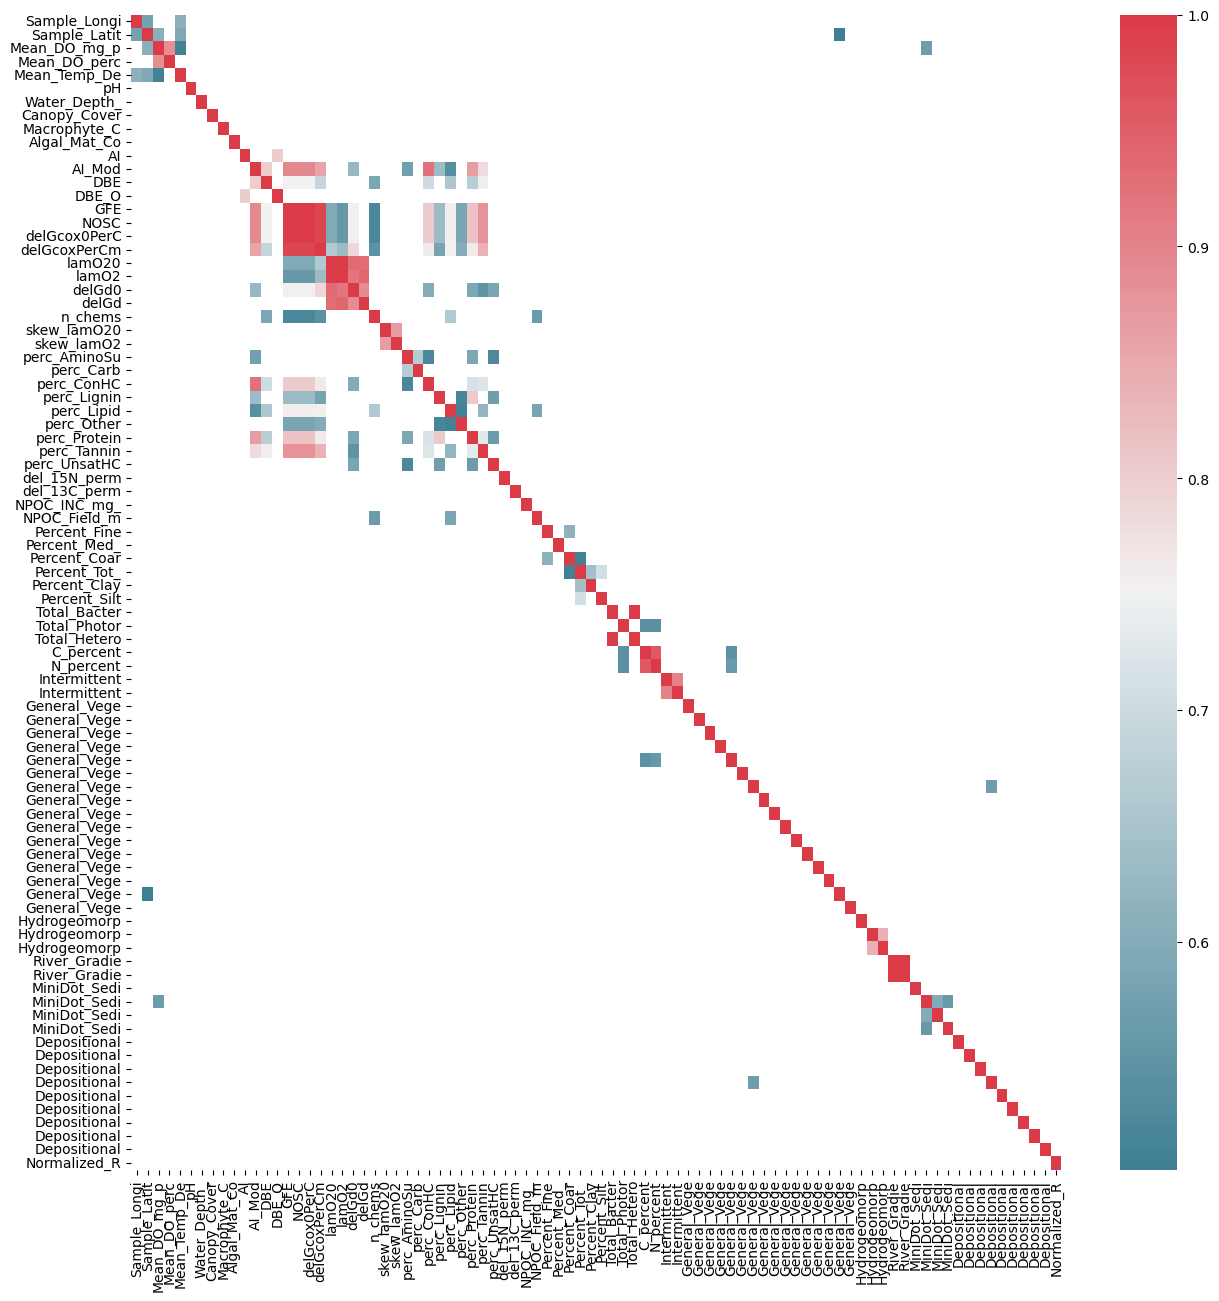

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
short_names = [name[:12] for name in corr.columns]
sns.heatmap(ax=ax, data=np.abs(hot_spots), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))
